# Neural Machine Translation with Attention Model


In this notebook, we  will build a Neural Machine Translation (NMT) model to translate human readable dates ("28th of September, 2009") into machine readable dates ("2009-09-28"). We will do this with an attention model, which is used to learn sophisticated mappings from one sequence to another.

Let's load all the packages. 

In [2]:
#import matplotlib
#matplotlib.use('Agg')
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt

%matplotlib inline

## Translating human readable dates into machine readable dates

The attention model can be used to translate from one language to another but that task will require large training dataset and a lot of time training on GPUs. Hence in order to explore the functionality of this model, we will instead use it to translate dates written in a variety of formats to machine readable dates.
For example, 
- $"the 29th of August 1958"$ to $"1958-08-29"$

- $"03/30/1968"$ to $"1968-03-30"$

- $"24 JUNE 1987"$ to  $"1987-06-24"$.



### Dataset

For trainig, we will use a dataset of 10000 dates in different formats and their equivalent machine readable dates.

Let's print some examples.

In [3]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16272.14it/s]


In [4]:
# lets load some sample dates and their corresponding machine readable dates

dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

The data we have loaded has,
- `dataset`: a list of tuples of (human readable date, machine readable date)
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index.  
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

In [5]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


We now have:
- `X`: where each character in the human readable dates is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x = 30$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: where each character in machine readable dates is replaced by the index it is mapped to in `machine_vocab`. `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`,
- `Yoh`: one-hot version of `Y`.


In [6]:
index = 9
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: monday may 22 1995
Target date: 1995-05-22

Source after preprocessing (indices): [24 26 25 16 13 34  0 24 13 34  0  5  5  0  4 12 12  8 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  6  0  1  6  0  3  3]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


## Neural machine translation with attention

Let's take a look at out Model.

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. If we are to translate a sentence from one language to another, especially if its a long sentence or a paragraph, we don't read the whole paragraph and translate it, but we pay attention to a few words in a paragraph like negation or conjugation and then translate the paragraph in pieces. That's what attention model does.


###  Attention mechanism

Here is a figure of how the model works. The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Source**: Coursera.org, Deep Learning Specialization.</center></caption>



Here are some properties of the model that you may notice: 

- The LSTM at the bottom is a Bi-directional LSTM and comes before the attention model and the one at the top a one-directional LSTM. The pre-attention LSTM goes through $T_x$ time steps while the post attantion LSTM goes though $T_y$ time steps. We use two LSTMs here because $T_x$ is not necessarily equal to $T_y$.

- In the figure on the right, where we implement the one step of the attention model, for a given time step ($t$), we take as input all the Hidden states of the Bi_LSTM and the previous hiddent state ($t-1$) of the post-attention LSTM. The output gives us a weighted sum of all the hidden states. The weights here decide how each character in the sentence ( or a date in this case) influences the character at time step $t$. The model will learn this influence and will try to replicate it when we test it on a new data. 


**1) `one_step_attention()`**: At step $t$, given all the hidden states of the Bi-LSTM ($[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$) and the previous hidden state of the second LSTM ($s^{<t-1>}$), `one_step_attention()` will compute the attention weights ($[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$) and output the context vector (see Figure  1 (right) for details):
$$context^{<t>} = \sum_{t' = 0}^{T_x} \alpha^{<t,t'>}a^{<t'>}$$

  
**2) `model()`**: Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. Then, it calls `one_step_attention()` $T_y$ times (`for` loop). At each iteration of this loop, it gives the computed context vector $c^{<t>}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{<t>}$. 



In [7]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') 
dotor = Dot(axes = 1)

In [8]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) to
    #concatenate it with all hidden states "a" 
    s_prev = repeator(s_prev)
   # print(s_prev.shape)
    # Use concatenator to concatenate a and s_prev on the last axis 
    concat = concatenator([a , s_prev])
    #print(concat.shape)
    
    # Use densor1 to propagate concat through a small fully-connected 
    # neural network to compute the "intermediate energies" variable e. 
    e = densor1(concat)
    #print(e.shape)
    # Use densor2 to propagate e through a small fully-connected neural 
    # network to compute the "energies" variable energies. 
    energies = densor2(e)
    #print(energies.shape)
    # Use "activator" on "energies" to compute the attention weights "alphas" 
    alphas = activator(energies)
    #print(alphas.shape)
    # Use dotor together with "alphas" and "a" to compute the context vector
    # to be given to the next (post-attention) LSTM-cell 
    context = dotor([alphas,a])
    #print(context.shape)
    #print(context.shape)
    
    return context

In [9]:
# Define global layers that will share weights to be used in 'model()'

n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [54]:

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of the model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    
    # Step 1: Define  pre-attention Bi-LSTM.. 
    a = Bidirectional( LSTM(n_a, return_sequences=True ))(X)
    #print(a.shape)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a , s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        #  initial_state = [hidden state, cell state] 
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s,c])
        
        # Step 2.C: Applying Dense layer to the hidden state output of the post-attention LSTM 
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list 
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. 
    model = Model(inputs = [X,s0,c0], outputs = outputs)
    
    
    return model

In [11]:

modelb = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
#model_use = modela
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999) # decay=0.01)
modelb.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'] )
#modelb.summary()
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))
modelb.fit([Xoh, s0, c0], outputs, epochs=10, batch_size=100, verbose = 2)

Epoch 1/10
 - 21s - loss: 15.3400 - dense_3_loss: 2.5427 - dense_3_acc: 0.5409 - dense_3_acc_1: 0.7211 - dense_3_acc_2: 0.3395 - dense_3_acc_3: 0.0812 - dense_3_acc_4: 0.9815 - dense_3_acc_5: 0.4517 - dense_3_acc_6: 0.0938 - dense_3_acc_7: 0.9269 - dense_3_acc_8: 0.2795 - dense_3_acc_9: 0.1036
Epoch 2/10
 - 11s - loss: 8.7964 - dense_3_loss: 2.2337 - dense_3_acc: 0.9682 - dense_3_acc_1: 0.9669 - dense_3_acc_2: 0.5621 - dense_3_acc_3: 0.1861 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9379 - dense_3_acc_6: 0.3298 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.4921 - dense_3_acc_9: 0.1740
Epoch 3/10
 - 12s - loss: 7.0478 - dense_3_loss: 2.0872 - dense_3_acc: 0.9777 - dense_3_acc_1: 0.9767 - dense_3_acc_2: 0.7124 - dense_3_acc_3: 0.3778 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9621 - dense_3_acc_6: 0.5710 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.5813 - dense_3_acc_9: 0.2310
Epoch 4/10
 - 12s - loss: 5.0405 - dense_3_loss: 1.8823 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9811 - dense_3_acc_2

## Test on few examples

In [12]:
from numpy import newaxis
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']


for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    #print(human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))#.swapaxes(0,1)
    #print(source.shape)
    source = source[newaxis,:,:]
    #print(source.shape)
    prediction = modelb.predict([source,s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


### Getting the activations from the network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [13]:
modelb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

In [51]:
def plot_attn_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 64, num = 7 , Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # Normalize attention map
#     row_max = attention_map.max(axis=1)
#     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure()
    f.set_figwidth(18)
    f.set_figheight(8.5)
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='gray')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0.0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

On the generated plot we can observe the values of the attention weights for each character of the predicted output. 

In the date translation application, we will observe that most of the time attention helps predict the date/month, and hasn't much impact on predicting the year .

<Figure size 432x288 with 0 Axes>

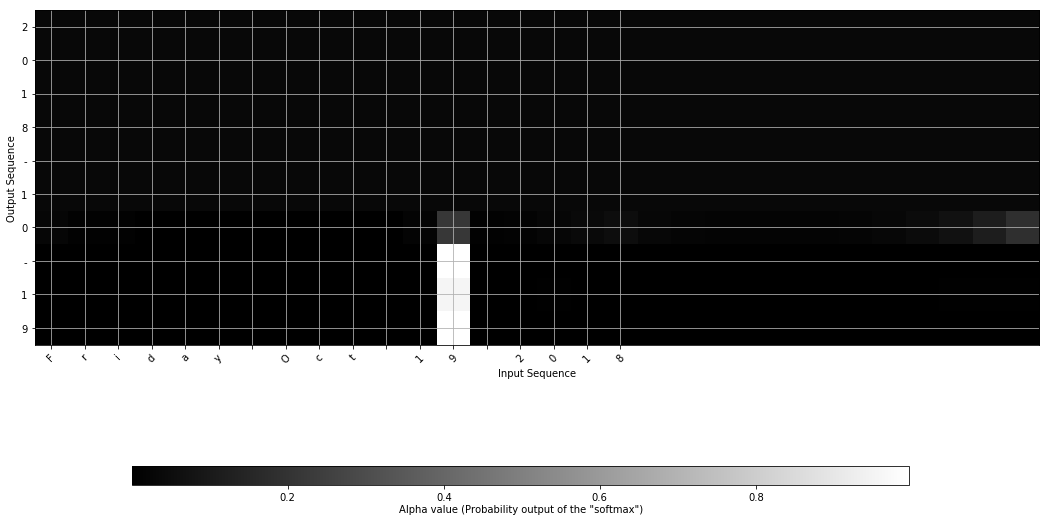

In [52]:
attention_map = plot_attn_map(modelb, human_vocab, inv_machine_vocab, "Friday Oct 19 2018", num = 7, n_s = 64)

<Figure size 432x288 with 0 Axes>

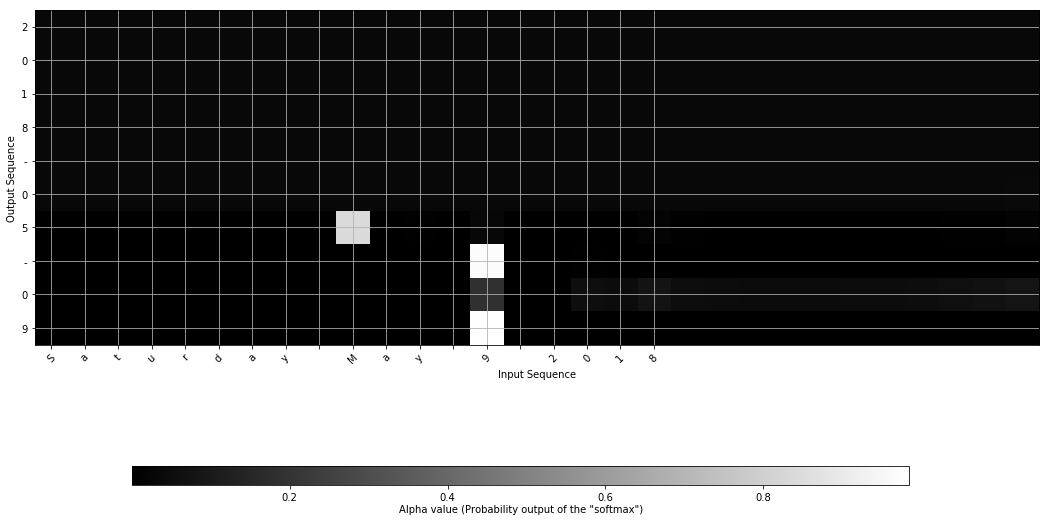

In [53]:
attention_map = plot_attn_map(modelb, human_vocab, inv_machine_vocab, "Saturday May 9 2018", num = 7, n_s = 64)

The ideas in this notebook are based on Andrew Ng's Deep Learning Specialization on Coursera.org.